### Merging of Three Datasets: Chart data, audio data, song lyrics
# CSV Merge Plan

## Goal
Merge Billboard chart data with Spotify audio features

## Approach
Keep time-series structure - **one row per song per week**

## Steps
1. Load both CSVs (chart data + audio features)
2. Merge on `Song` + `Performer` columns
3. This adds audio feature columns to every weekly chart entry
4. Report matching statistics:
   - How many unique songs in chart data
   - How many unique songs in audio data
   - How many songs successfully matched
   - How many songs couldn't be matched (from each dataset)

## Result
Each weekly chart entry now has audio features attached, preserving the 
time-series structure for ML modeling

In [1]:
import pandas as pd
import re
from rapidfuzz import process, fuzz

# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Load data
chart_df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\chartfeatures.csv")
audio_df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\Hot 100 Audio Features.csv")

# Clean song and artist columns
chart_df['clean_song'] = chart_df['Song'].apply(clean_text)
chart_df['clean_artist'] = chart_df['Performer'].apply(clean_text)
audio_df['clean_song'] = audio_df['Song'].apply(clean_text)
audio_df['clean_artist'] = audio_df['Performer'].apply(clean_text)

# Create match keys
chart_df['match_key'] = chart_df['clean_song'] + '|' + chart_df['clean_artist']
audio_df['match_key'] = audio_df['clean_song'] + '|' + audio_df['clean_artist']

# Exact match
exact_merge = chart_df.merge(audio_df, on='match_key', how='left', suffixes=('', '_audio'))

# Separate unmatched and matched - use spotify_track_id since audio columns DON'T get suffix
unmatched_chart = exact_merge[exact_merge['spotify_track_id'].isna()].copy()
matched_chart = exact_merge[exact_merge['spotify_track_id'].notna()].copy()

print(f"Exact matches: {len(matched_chart)}")
print(f"Need fuzzy matching: {len(unmatched_chart)}")

Exact matches: 287271
Need fuzzy matching: 43331


In [ ]:
from tqdm import tqdm

# Remove duplicates from audio_df - keep first occurrence of each song
audio_df_unique = audio_df.drop_duplicates(subset='match_key', keep='first')
print(f"Audio dataset: {len(audio_df)} rows → {len(audio_df_unique)} unique songs")

# Create lookup dictionary for audio data
audio_lookup = audio_df_unique.set_index('match_key').to_dict('index')
audio_keys = list(audio_lookup.keys())

# Fuzzy match unmatched songs with progress bar
fuzzy_matches = []
for idx, row in tqdm(unmatched_chart.iterrows(), total=len(unmatched_chart), desc="Fuzzy Matching"):
    chart_key = row['match_key']
    match = process.extractOne(chart_key, audio_keys, scorer=fuzz.ratio, score_cutoff=85)
    if match:
        best_match_key, score, _ = match
        fuzzy_matches.append({
            'chart_idx': idx,
            'chart_key': chart_key,
            'audio_key': best_match_key,
            'score': score
        })

print(f"\nFuzzy matches found: {len(fuzzy_matches)}")

# Apply fuzzy matches
for match in fuzzy_matches:
    audio_data = audio_lookup[match['audio_key']]
    for col, val in audio_data.items():
        if col not in ['match_key', 'clean_song', 'clean_artist']:
            unmatched_chart.at[match['chart_idx'], col] = val

# Combine exact and fuzzy matches
final_df = pd.concat([matched_chart, unmatched_chart], ignore_index=True)

# Report statistics
print("FINAL MERGE STATISTICS")
print(f"Total chart entries: {len(chart_df)}")
print(f"Exact matches: {len(matched_chart)}")
print(f"Fuzzy matches: {len(fuzzy_matches)}")
print(f"Total matched: {final_df['spotify_track_id'].notna().sum()}")
print(f"Still unmatched: {final_df['spotify_track_id'].isna().sum()}")
print(f"Overall match rate: {(final_df['spotify_track_id'].notna().sum() / len(final_df) * 100):.2f}%")

# Save final merged CSV
final_df.to_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio.csv", index=False)

Audio dataset: 29503 rows → 29379 unique songs


Fuzzy Matching: 100%|██████████| 43331/43331 [00:47<00:00, 906.12it/s] 



Fuzzy matches found: 43326

=== FINAL MERGE STATISTICS ===
Total chart entries: 327895
Exact matches: 287271
Fuzzy matches: 43326
Total matched: 287311
Still unmatched: 43291
Overall match rate: 86.91%


In [ ]:
from tqdm import tqdm

# Load lyrics dataset
lyrics_df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\song_lyrics.csv")

print(f"Lyrics dataset: {len(lyrics_df)} rows")

# Clean the lyrics dataset
lyrics_df['clean_song'] = lyrics_df['title'].apply(clean_text)
lyrics_df['clean_artist'] = lyrics_df['artist'].apply(clean_text)
lyrics_df['match_key'] = lyrics_df['clean_song'] + '|' + lyrics_df['clean_artist']

# Remove duplicates
lyrics_df_unique = lyrics_df.drop_duplicates(subset='match_key', keep='first')

# Select columns to merge
lyrics_cols = lyrics_df_unique[['match_key', 'tag', 'year', 'views', 'features', 'lyrics', 'language_cld3']]

# STEP 1: Exact match
exact_lyrics_merge = final_df.merge(lyrics_cols, on='match_key', how='left', suffixes=('', '_lyrics'))

matched_lyrics = exact_lyrics_merge[exact_lyrics_merge['lyrics'].notna()].copy()
unmatched_lyrics = exact_lyrics_merge[exact_lyrics_merge['lyrics'].isna()].copy()

print(f"\nExact lyrics matches: {len(matched_lyrics)}")
print(f"Need fuzzy matching: {len(unmatched_lyrics)}")

# STEP 2: Optimized fuzzy matching - only match UNIQUE unmatched songs
unique_unmatched = unmatched_lyrics[['match_key']].drop_duplicates()
print(f"Unique unmatched songs to fuzzy match: {len(unique_unmatched)}")

lyrics_lookup = lyrics_df_unique.set_index('match_key')[['tag', 'year', 'views', 'features', 'lyrics', 'language_cld3']].to_dict('index')
lyrics_keys = list(lyrics_lookup.keys())

# Create mapping for unique songs only
fuzzy_mapping = {}
for chart_key in tqdm(unique_unmatched['match_key'], desc="Fuzzy Matching Lyrics"):
    match = process.extractOne(chart_key, lyrics_keys, scorer=fuzz.ratio, score_cutoff=85)
    if match:
        best_match_key, score, _ = match
        fuzzy_mapping[chart_key] = best_match_key

print(f"\nFuzzy matches found: {len(fuzzy_mapping)}")

# Apply fuzzy matches to all rows
for chart_key, lyrics_key in fuzzy_mapping.items():
    lyrics_data = lyrics_lookup[lyrics_key]
    mask = unmatched_lyrics['match_key'] == chart_key
    for col, val in lyrics_data.items():
        unmatched_lyrics.loc[mask, col] = val

# Combine exact and fuzzy matches
final_df_with_lyrics = pd.concat([matched_lyrics, unmatched_lyrics], ignore_index=True)

# Report statistics
print("FINAL LYRICS MERGE STATISTICS")
print(f"Total entries: {len(final_df_with_lyrics)}")
print(f"Exact matches: {len(matched_lyrics)}")
print(f"Fuzzy matches: {len(fuzzy_mapping)} unique songs")
print(f"Total with lyrics: {final_df_with_lyrics['lyrics'].notna().sum()}")
print(f"Still without lyrics: {final_df_with_lyrics['lyrics'].isna().sum()}")
print(f"Overall lyrics match rate: {(final_df_with_lyrics['lyrics'].notna().sum() / len(final_df_with_lyrics) * 100):.2f}%")

# Save
final_df_with_lyrics.to_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio_lyrics.csv", index=False)
print("\n✓ Complete!")

Lyrics dataset: 5134856 rows

Exact lyrics matches: 233046
Need fuzzy matching: 97556
Unique unmatched songs to fuzzy match: 9913


Fuzzy Matching Lyrics: 100%|██████████| 9913/9913 [57:29<00:00,  2.87it/s] 



Fuzzy matches found: 2788

=== FINAL LYRICS MERGE STATISTICS ===
Total entries: 330602
Exact matches: 233046
Fuzzy matches: 2788 unique songs
Total with lyrics: 262113
Still without lyrics: 68489
Overall lyrics match rate: 79.28%

✓ Complete!


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio_lyrics.csv")
print(f"Step 1 - Original: {len(df)} rows")
print(f"Unique SongIDs: {df['SongID'].nunique()}")

# Remove duplicates
df = df.drop_duplicates()
print(f"\nStep 2 - After removing duplicates: {len(df)} rows")
print(f"Duplicates removed: {330602 - len(df)}")

# Check instances before aggregation
print(f"\n=== BEFORE AGGREGATION ===")
print(f"Unique songs: {df['SongID'].nunique()}")
print(f"Total rows (weekly entries): {len(df)}")

# Example: Check Mariah's song before aggregation
mariah_before = df[df['Song'].str.contains('All I Want For Christmas', case=False, na=False)]
if len(mariah_before) > 0:
    print(f"\nMariah's Christmas song - Weekly entries: {len(mariah_before)}")
    print(f"Instances: {mariah_before['Instance'].unique()}")
    print(f"Max 'Weeks on Chart' per instance:")
    print(mariah_before.groupby('Instance')['Weeks on Chart'].max())

# ========================================
# OPTIMIZED: Calculate total weeks efficiently
# ========================================
weeks_per_instance = df.groupby(['SongID', 'Instance'])['Weeks on Chart'].max().reset_index()
total_weeks = weeks_per_instance.groupby('SongID')['Weeks on Chart'].sum()

# ========================================
# Aggregate to song level (WITH ALL SPOTIFY FEATURES)
# ========================================
audio_features = ['danceability', 'energy', 'valence', 'tempo', 
                  'acousticness', 'loudness', 'speechiness', 'instrumentalness', 'liveness']

# All Spotify metadata to keep
spotify_metadata = ['spotify_genre', 'spotify_track_id', 'spotify_track_duration_ms', 
                    'spotify_track_explicit', 'spotify_track_album', 'spotify_track_preview_url',
                    'spotify_track_popularity', 'time_signature', 'key', 'mode','WeekID']

song_level = df.groupby('SongID').agg({
    # Performance metrics
    'Peak Position': 'min',
    'Instance': 'max',
    'Week Position': 'mean',
    
    # Song info
    'Song': 'first',
    'Performer': 'first',
    
    # Audio features
    **{feat: 'first' for feat in audio_features},
    
    # Spotify metadata (the ones you forgot!)
    **{feat: 'first' for feat in spotify_metadata},
    
    # Temporal
    'year': 'first',
    
    # Lyrics
    'lyrics': 'first',
    'tag': 'first',
    'language_cld3': 'first'
}).reset_index()

# Add the precomputed total weeks
song_level = song_level.merge(total_weeks.rename('Total_Weeks'), on='SongID', how='left')

# Rename Instance column
song_level = song_level.rename(columns={'Instance': 'Num_Chart_Runs'})

print(f"\n=== AFTER AGGREGATION ===")
print(f"✓ ONE ROW PER SONG: {len(song_level)} unique songs")
print(f"✓ Each song appears exactly once")
print(f"✓ Total columns: {len(song_level.columns)}")

# Verify: Check if any duplicates
assert song_level['SongID'].nunique() == len(song_level), "ERROR: Still have duplicates!"
print("✓ Verification passed: No duplicate SongIDs")

# Show all columns
print(f"\n=== ALL COLUMNS IN FINAL DATASET ===")
print(song_level.columns.tolist())

# Check Mariah's song after aggregation
mariah_after = song_level[song_level['Song'].str.contains('All I Want For Christmas', case=False, na=False)]
if len(mariah_after) > 0:
    print(f"\n=== MARIAH'S CHRISTMAS SONG - AGGREGATED ===")
    print(mariah_after[['Song', 'Performer', 'Total_Weeks', 'Num_Chart_Runs', 'Peak Position', 
                        'spotify_genre', 'spotify_track_explicit']])
    print(f"\nTotal weeks across all chart runs: {mariah_after['Total_Weeks'].values[0]}")

# Statistics
print(f"\n=== DATASET STATISTICS ===")
print(f"Total Weeks distribution:")
print(song_level['Total_Weeks'].describe())
print(f"\nSongs with multiple chart runs: {(song_level['Num_Chart_Runs'] > 1).sum()}")
print(f"Percentage: {(song_level['Num_Chart_Runs'] > 1).sum() / len(song_level) * 100:.1f}%")

# Check Spotify feature coverage
print(f"\n=== SPOTIFY FEATURE COVERAGE ===")
print(f"Songs with spotify_track_id: {song_level['spotify_track_id'].notna().sum()} ({song_level['spotify_track_id'].notna().sum()/len(song_level)*100:.1f}%)")
print(f"Songs with genre: {song_level['spotify_genre'].notna().sum()} ({song_level['spotify_genre'].notna().sum()/len(song_level)*100:.1f}%)")
print(f"Songs with explicit flag: {song_level['spotify_track_explicit'].notna().sum()} ({song_level['spotify_track_explicit'].notna().sum()/len(song_level)*100:.1f}%)")

# Top songs by longevity
print(f"\n=== TOP 10 LONGEST-CHARTING SONGS ===")
top_songs = song_level.nlargest(10, 'Total_Weeks')[['Song', 'Performer', 'Total_Weeks', 'Num_Chart_Runs', 'Peak Position']]
print(top_songs.to_string(index=False))

print("\n✓✓✓ SUCCESS: One row per song, instances properly aggregated! ✓✓✓")

# Save the cleaned dataset
song_level.to_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\song_level_aggregated.csv", index=False)
print("\n✓ Saved aggregated dataset to 'song_level_aggregated.csv'")
print(f"✓ Total features saved: {len(song_level.columns)}")

C:\Users\joshu\AppData\Local\Temp\ipykernel_49824\4234899445.py:7: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio_lyrics.csv")


Step 1 - Original: 330602 rows
Unique SongIDs: 29385

Step 2 - After removing duplicates: 330602 rows
Duplicates removed: 0

=== BEFORE AGGREGATION ===
Unique songs: 29385
Total rows (weekly entries): 330602

Mariah's Christmas song - Weekly entries: 88
Instances: [ 1  2  3  4  5  6  7  8  9 10]
Max 'Weeks on Chart' per instance:
Instance
1      1
2      4
3      7
4     10
5     14
6     19
7     23
8     29
9     36
10    43
Name: Weeks on Chart, dtype: int64

=== AFTER AGGREGATION ===
✓ ONE ROW PER SONG: 29385 unique songs
✓ Each song appears exactly once
✓ Total columns: 31
✓ Verification passed: No duplicate SongIDs

=== ALL COLUMNS IN FINAL DATASET ===
['SongID', 'Peak Position', 'Num_Chart_Runs', 'Week Position', 'Song', 'Performer', 'danceability', 'energy', 'valence', 'tempo', 'acousticness', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'spotify_genre', 'spotify_track_id', 'spotify_track_duration_ms', 'spotify_track_explicit', 'spotify_track_album', 'spotify_trac

C:\Users\joshu\AppData\Local\Temp\ipykernel_49824\606219199.py:6: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio_lyrics.csv")


🎵 Top Genres:
dance pop               48268
mellow gold             47410
soft rock               46859
pop                     46413
rock                    39336
adult standards         36277
pop rap                 34077
album rock              29440
brill building pop      28799
urban contemporary      28738
rap                     28623
quiet storm             27274
soul                    27225
r&b                     27044
classic rock            26971
motown                  26881
folk rock               26308
hip hop                 25979
country                 25492
contemporary country    22900
Name: count, dtype: int64


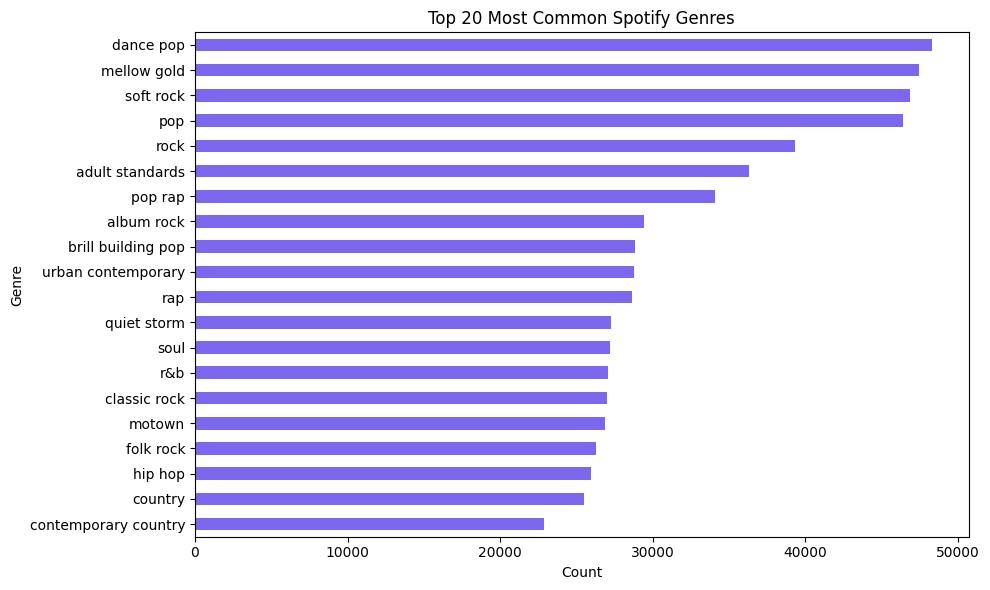

In [8]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load your data (update path as needed)
df = pd.read_csv(r"C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\merged_chart_audio_lyrics.csv")

# Drop missing genres
df = df.dropna(subset=['spotify_genre'])

# Convert genre strings like "['rock', 'pop']" → Python lists
df['spotify_genre'] = df['spotify_genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Flatten all genres into a single list
all_genres = [genre for sublist in df['spotify_genre'] for genre in sublist]

# Count frequency
genre_counts = pd.Series(all_genres).value_counts().head(20)  # top 20 genres

# Print most common genres
print("🎵 Top Genres:")
print(genre_counts)

# Plot
plt.figure(figsize=(10,6))
genre_counts.sort_values().plot(kind='barh', color='mediumslateblue')
plt.title("Top 20 Most Common Spotify Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()
